In [1]:
import dill
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp

with open("../results/tone_1.kHz-default-2024-05-29T20:37:15.6.pic", "rb") as f:
    default_result = dill.load(f, ignore="True")

with open("../results/tone_1.kHz-no_inh-2024-05-29T20:55:54.6.pic", "rb") as f:
    no_inh_result = dill.load(f, ignore="True")


In [2]:
def draw_rate_vs_angle(data):
    angle_to_rate = data["angle_to_rate"]
    name = data["conf"]["model_desc"]["name"]
    old_to_new = {
        '90': -90,
        '75': -75,
        '60': -60,
        '45': -45,
        '30': -30,
        '15': -15,
        '0': 0,
        '345': 15,
        '330': 30,
        '315': 45,
        '300': 60,
        '285': 75,
        '270': 90,
    }
    result = {}
    for angle,res in angle_to_rate.items():
        result[old_to_new[str(angle)]] = res
    
    angles = list(result.keys())

    arr_n_spikes_r_lso = [x["n_spikes_r_lso"] for angle, x in result.items()]
    arr_n_spikes_l_lso = [x["n_spikes_l_lso"] for angle, x in result.items()]
    arr_n_spikes_r_mso = [x["n_spikes_r_mso"] for angle, x in result.items()]
    arr_n_spikes_l_mso = [x["n_spikes_l_mso"] for angle, x in result.items()]
    print(arr_n_spikes_r_mso)
    fig, [lso, mso] = plt.subplots(2, 1)

    plt.setp([lso,mso], xticks = angles)
    lso.scatter(angles, arr_n_spikes_r_lso, label="right lso")

    lso.scatter(angles, arr_n_spikes_l_lso, label="left lso")
    lso.set_ylabel("total spikes")
    _ = lso.legend()

    mso.scatter(angles, arr_n_spikes_r_mso, label="right mso")

    mso.scatter(angles, arr_n_spikes_l_mso, label="left mso")

    mso.set_xlabel("sound position")
    mso.set_ylabel("total spikes")
    _ = mso.legend()

[107, 125, 110, 115, 99, 104, 88, 87, 75, 77, 86, 87, 84]
[204, 219, 215, 200, 191, 179, 182, 183, 206, 216, 223, 229, 233]


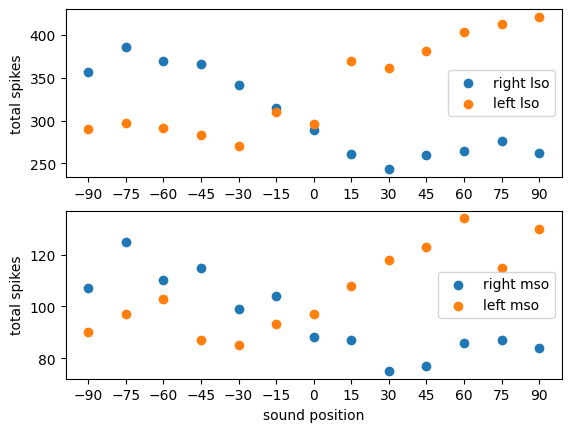

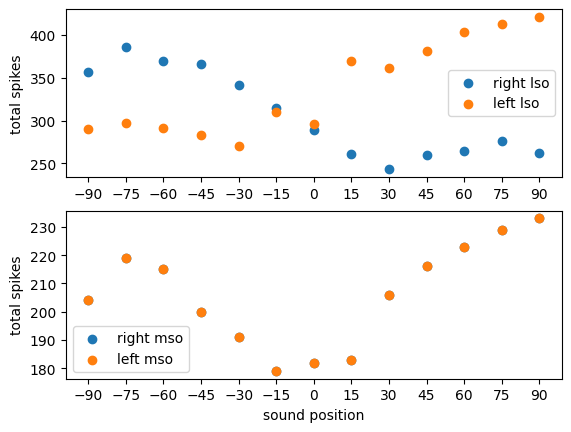

In [3]:
draw_rate_vs_angle(default_result)
draw_rate_vs_angle(no_inh_result)
